<h1>Лабораторная работа № 5</h1>

Импорт необходимых модулей

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataframe_process as my_module
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from pymystem3 import Mystem
from torch.autograd import Variable

nlp = spacy.load("ru_core_news_md")
stopwords_ru = list(nlp.Defaults.stop_words)

Загрузка обработанных данных

In [29]:
data = pd.read_csv("data.csv", )
data = data.drop("Index", axis=1)
data

,Название,Тип рецензии,Текст рецензии,Количество слов
0,Тьма,0,вчера наконец досматривать тьма сразу сказать ...,667
1,Тьма,0,я писать данный ревивать исключительно потому ...,625
2,Тьма,0,не быть описывать содержание нет смысл сразу к...,527
3,Тьма,0,никогда такой не быть и вот опятьпоминаться в ...,337
4,Тьма,0,о данный сериал я услышать совсем недавно и у ...,817
...,...,...,...,...
1995,1+1,1,начинать с тот что фильм у мы в страна показыв...,306
1996,1+1,1,легкость казаться бы она не мочь быть ни у чел...,307
1997,1+1,1,без всякий предисловие сразу сказать что это х...,349
1998,1+1,1,большинство французский фильм всегда наполнять...,338


Загрузка даныых в датасет из csv файла

In [122]:
data = my_module.create_dataframe("c:\\Users\\Acer\\Documents\\py_lab_2\\annotations_3.csv")
data

KeyboardInterrupt: 

Предобработка датафрейма

In [18]:
m = Mystem()
data["Текст рецензии"] = data["Текст рецензии"].apply(my_module.del_trash)
data["Текст рецензии"] = data["Текст рецензии"].apply(m.lemmatize)
data["Текст рецензии"] = data["Текст рецензии"].apply("".join)
data["Текст рецензии"] = data["Текст рецензии"].apply(my_module.del_trash)
change_labels = lambda x: 1 if x=="good" else 0
data["Тип рецензии"] = data["Тип рецензии"].apply(change_labels)
data

KeyboardInterrupt: 

Сохранение обработанного датафрейма в csv файл

In [23]:
#data.to_csv("data.csv")

Векторизация текста

In [30]:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words=stopwords_ru)
sparse_matrix = cv.fit_transform(data["Текст рецензии"]).toarray()
feature_names = cv.get_feature_names_out()
words = feature_names.tolist()
sparse_matrix.shape

(2000, 10000)

Разделение на тренировочную, валидационную и тестовую выборки

In [32]:
def is_balanced(y_train: np.array, epsilon: int) -> bool:

    """Проверяет сбалансированна ли выборка"""

    unique, counts = np.unique(y_train, return_counts = True)
    d = dict(zip(unique, counts))
    print(d)
    if abs(d[0] - d[1]) <= epsilon:
        return True
    return False

In [33]:
x, x_test, y, y_test = train_test_split(sparse_matrix, np.array(data['Тип рецензии']), test_size = 0.2,train_size = 0.8)
x_train, x_v, y_train, y_v = train_test_split(x, y, test_size = 0.5, train_size = 0.5)
print(is_balanced(y_train, 50))
print(is_balanced(y_test, 30))
print(is_balanced(y_v, 30))

{0: 420, 1: 380}
True
{0: 187, 1: 213}
True
{0: 393, 1: 407}
True


Модель нейронной сети

In [34]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 20)
        self.linear3 = nn.Linear(20, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [35]:
criterion = nn.CrossEntropyLoss()

x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_v = Variable(torch.from_numpy(x_v)).float()
y_v = Variable(torch.from_numpy(y_v)).long()
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Цикл обучения

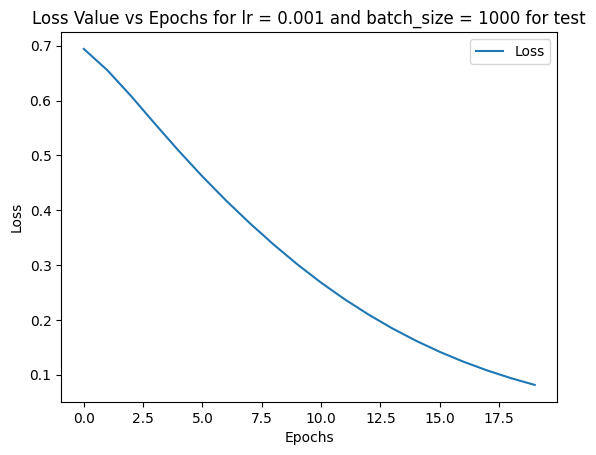

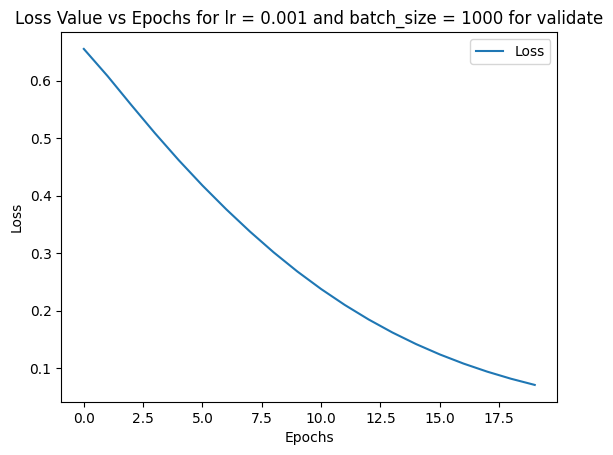

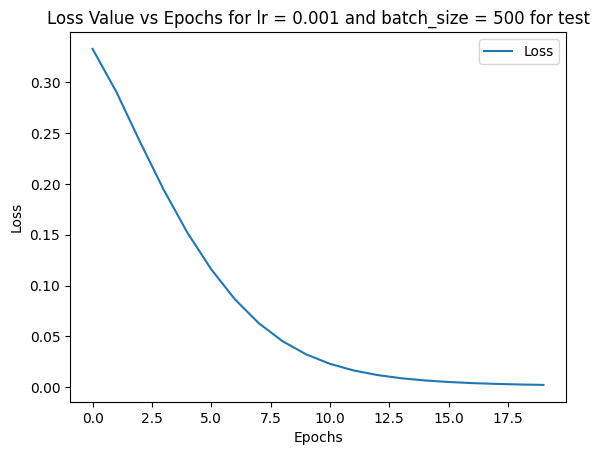

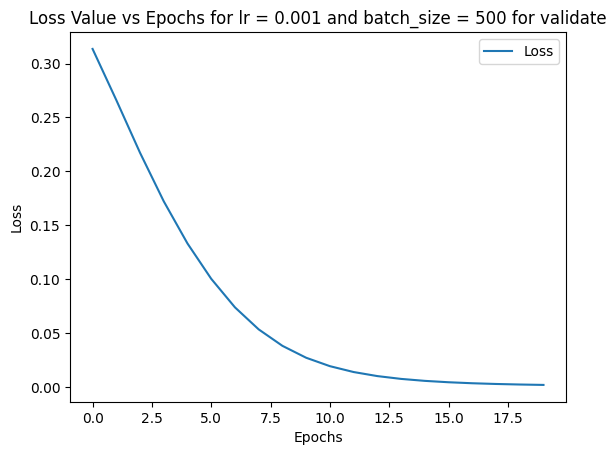

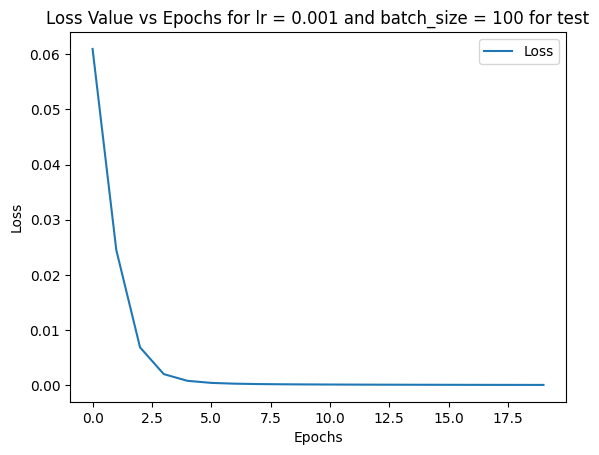

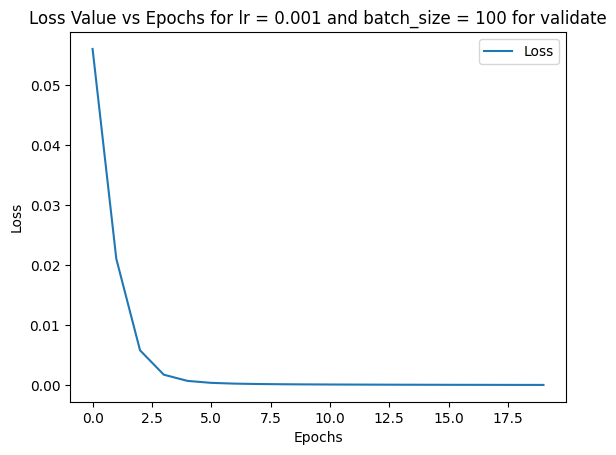

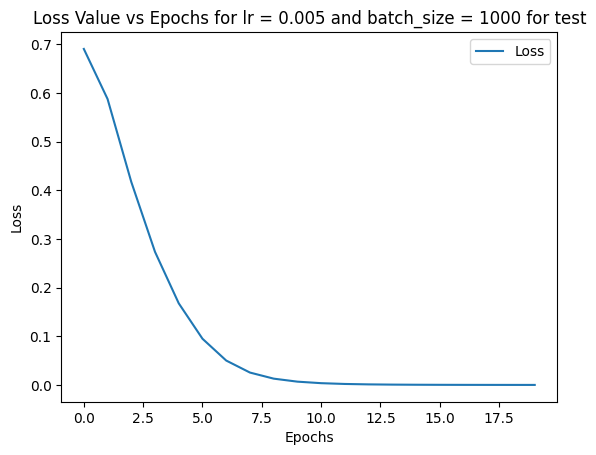

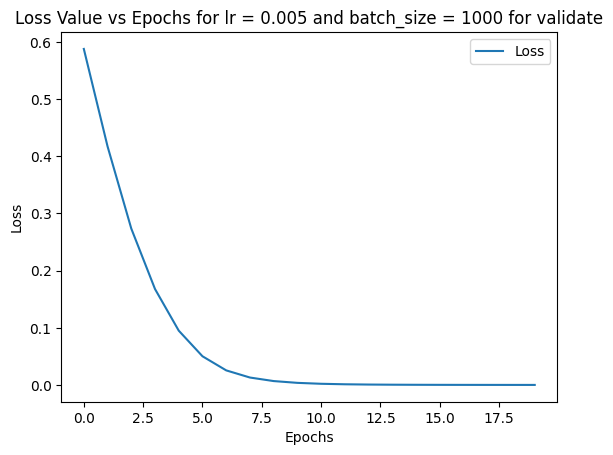

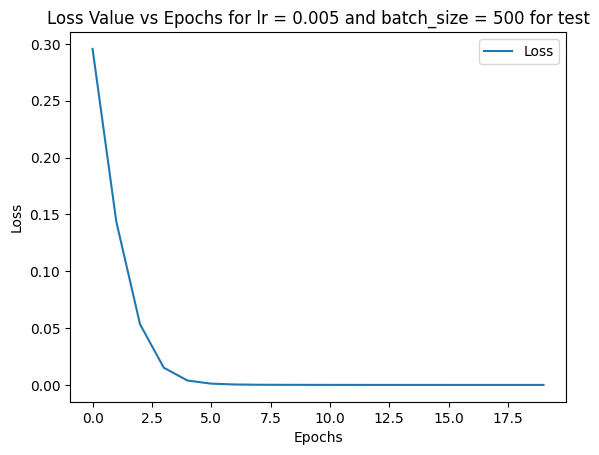

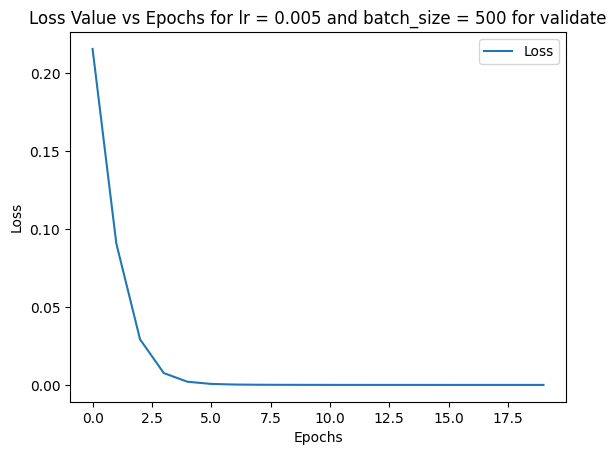

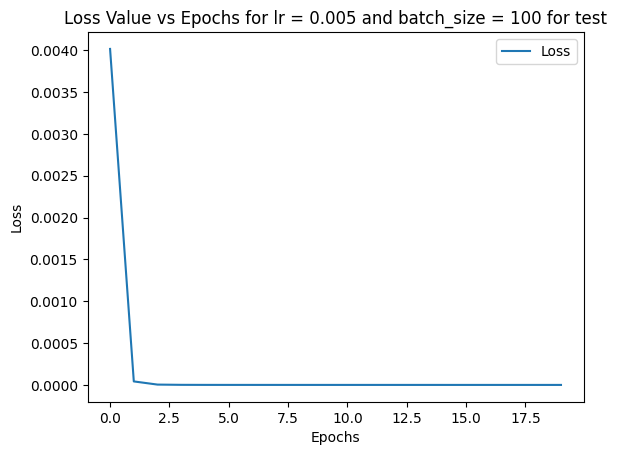

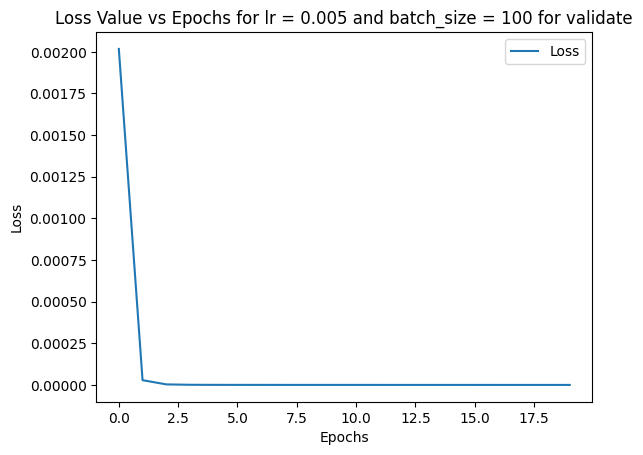

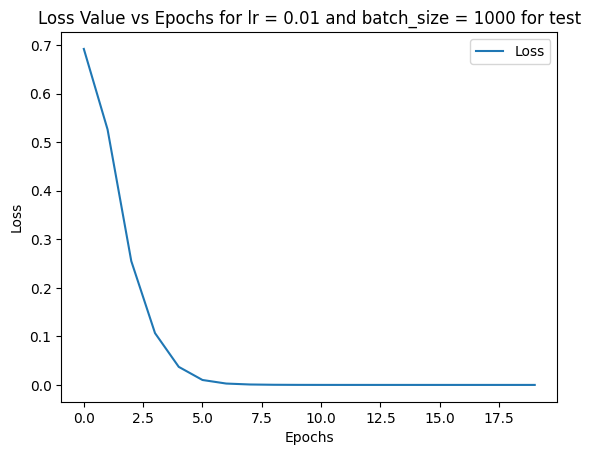

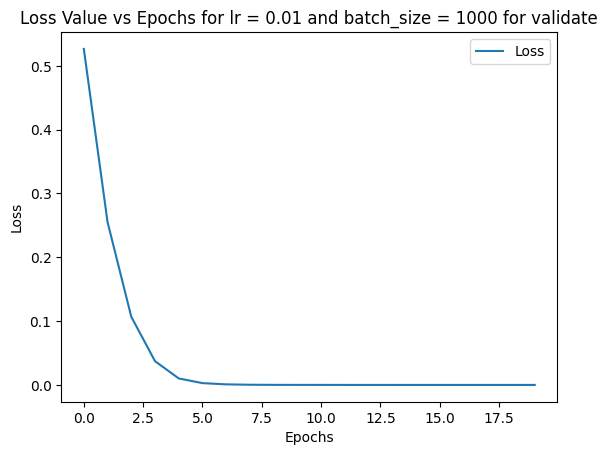

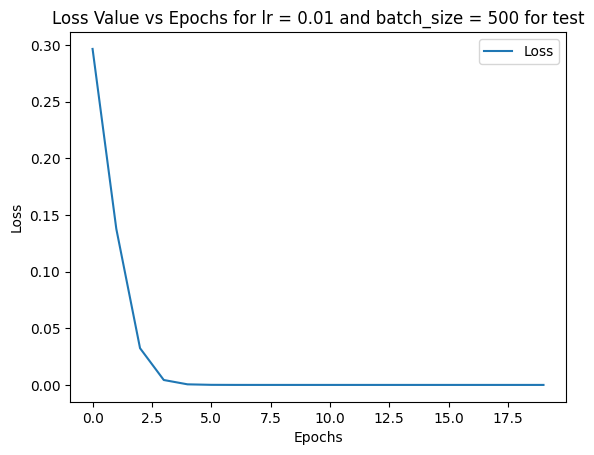

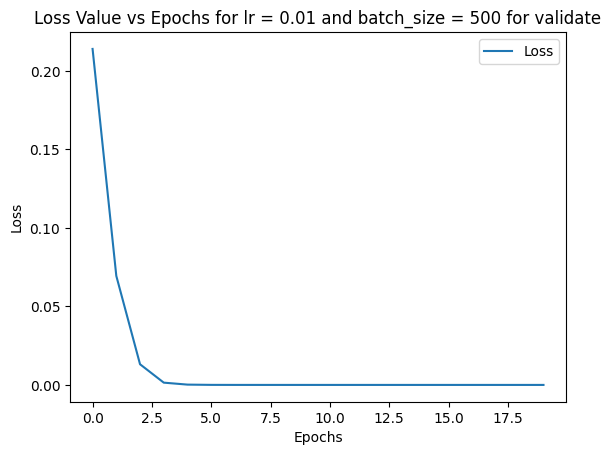

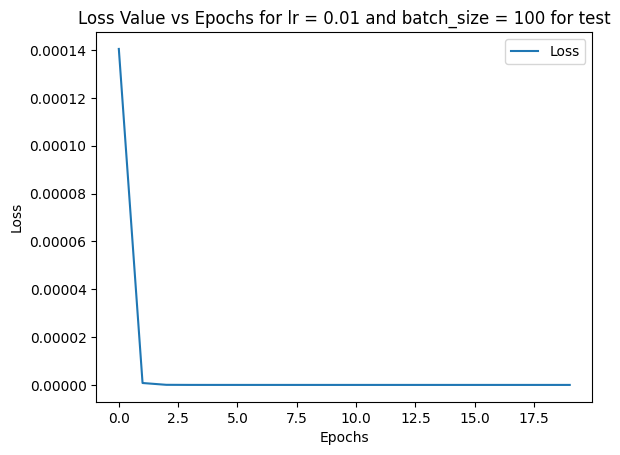

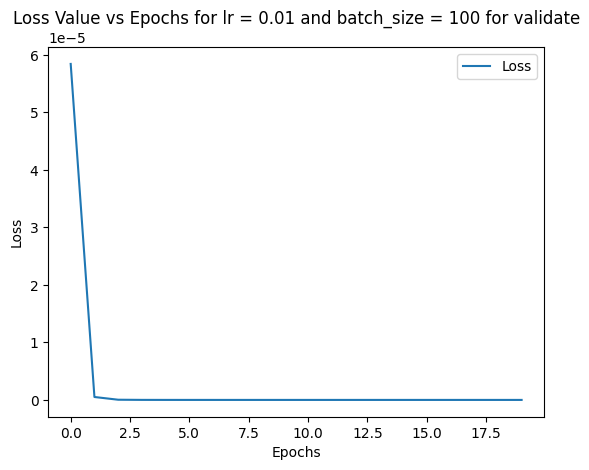

In [39]:
lr_list = [0.001, 0.005, 0.01]
batch_size=[1000, 500, 100]
for first_num, lr in enumerate(lr_list):
  for second_num, bs in enumerate(batch_size):
    model = LogisticRegression()
    data = torch.utils.data.DataLoader(x_train, batch_size=bs, shuffle=True)
    val_data = torch.utils.data.DataLoader(x_v, batch_size=bs, shuffle=True)
    optimizer = torch.optim.Adam(params=model.parameters() , lr=lr)
    epochs = 20
    model.train()
    loss_ = []
    loss_val=[]
    for epoch in range(epochs):
      for elem in data:
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      loss_.append(loss.item()/len(data))
      

      model.eval()
      for elem in val_data:
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
      loss_val.append(loss.item()/len(val_data))
      torch.save(model, f"c:\\Users\\Acer\\Documents\\py_lab_5\\model{first_num * 3 + second_num + 1}")

    plt.plot(loss_)
    plt.title(f'Loss Value vs Epochs for lr = {lr} and batch_size = {bs} for test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Loss'])
    plt.show()


      
    plt.plot(loss_val)
    plt.title(f'Loss Value vs Epochs for lr = {lr} and batch_size = {bs} for validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Loss'])
    plt.show()


Загрузка модели

In [41]:
model = torch.load("c:\\Users\\Acer\\Documents\\py_lab_5\\model4")
model

LogisticRegression(
  (linear1): Linear(in_features=10000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=2, bias=True)
)

In [42]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

Accuracy : 89.5%


In [46]:
m = Mystem()

def preprocess(comment: str) -> str:

    """Выполняет предобработку текста"""

    comment = my_module.del_trash(comment)
    comment = m.lemmatize(comment)
    return comment


def get_tensor(comment: str):
    tensor = 10000*[0]
    text = preprocess(comment)
    for word in set(text):
        if word in words:
            tensor[words.index(word)] = text.count(word)
    return torch.Tensor(tensor)


def return_mark(tensor: torch.Tensor):
    if(max(tensor) == tensor[0]):
        return "bad"
    return "good"
    


In [47]:
def predict(review: str) -> str:
    model.eval()
    with torch.no_grad():
        y_pred = model(get_tensor(review))
        return(return_mark(y_pred))
    

In [48]:
with open("c:\\Users\\Acer\\Documents\\py_lab_5\\final_test_comment.txt", "r", encoding = "utf-8") as f:
    comment = " ".join(f.readlines())
    print(predict(comment) == "bad")

True
